In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numdifftools as dif
import matplotlib as mpl

pi  = np.pi
cos = lambda x: np.cos(x)

In [2]:
#Define the brannin function with the typical parameters
def Brannin(x1,x2):
    a = 1 
    b = 5.1/(4*pi**2)
    c = 5/pi
    r = 6
    s = 10
    t = 1/(8*pi)
    return a*(x2-b * x1**2 + c*x1 - r)**2 + s*(1-t)*cos(x1) + s

In [3]:
# Define a mesh for exploration
x1 = np.linspace(-5,10,800)
x2 = np.linspace(0,15,800)

X1, X2 = np.meshgrid(x1,x2)

z = np.array([[Brannin(xx1,xx2) for xx1 in x1] for xx2 in x2]) 

# Since this is the same mesh we will use for testing the fitted model we will put it in a vector to compute the mean_sq_error

Xt = []
for xx1 in x1:
    for xx2 in x2:
        Xt.append([xx1,xx2])     
Xt = np.array(Xt)
YT = np.array([Brannin(xx1,xx2) for xx1,xx2 in Xt])

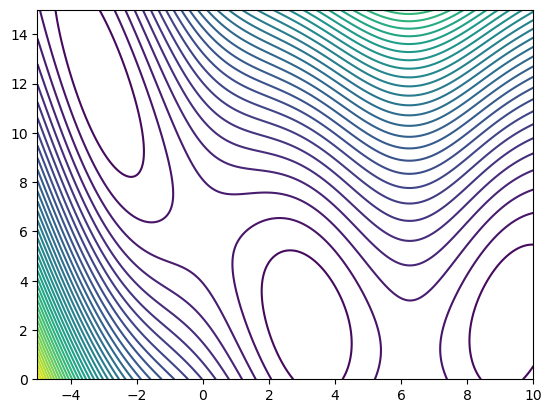

In [4]:
fig, ax = plt.subplots(1,1)
ax.contour(X1,X2,z,levels=50)

# Define the class of the single layer learner

In [23]:
class SingleLayer():

    def __init__(self,dim_in: int, dim_l: int, dim_o: int,th: float,alpha:float=1e-4,gamma:float=0.2):
        if(len(th)==dim_in*dim_l+dim_l+dim_l*dim_o+dim_o):
            self.alpha = alpha
            self.gamma = gamma
            self.dim_in = dim_in
            self.dim_l = dim_l
            self.dim_o = dim_o
            self.th = th
            self.Mil = th[:dim_in*dim_l].reshape(dim_l,dim_in)
            self.Mlo = th[dim_l*dim_in+dim_l:dim_l*dim_in+dim_l+dim_l*dim_o].reshape(dim_o,dim_l)
            self.bl = np.reshape(th[dim_in*dim_l:dim_in*dim_l+dim_l],(-1,1))
            self.bo = np.reshape(th[dim_l*dim_in+dim_l+dim_l*dim_o:],(-1,1))
            self.loss = 1
            self.loss_curve = []
        else:
            raise ValueError("Incorrect dimensions of single layer")
    
    def update_params(self,th_new):
        if(len(th_new)==self.dim_in*self.dim_l+self.dim_l+self.dim_l*self.dim_o+self.dim_o):
            self.th = th_new
            self.Mil = th_new[:self.dim_in*self.dim_l].reshape(self.dim_l,self.dim_in)
            self.Mlo = th_new[self.dim_l*self.dim_in+self.dim_l:
                self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o].reshape(self.dim_o,self.dim_l)
            self.bl = np.reshape(th_new[self.dim_in*self.dim_l:self.dim_in*self.dim_l+self.dim_l],(-1,1))
            self.bo = np.reshape(th_new[self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o:],(-1,1))
        else:
            raise ValueError("Incorrect dimensions when updating params")
        
    def predict(self,x):
        if(len(x)==self.dim_in):
            l = np.maximum(self.Mil@x.reshape(-1,1)+self.bl,np.zeros(self.dim_l).reshape(-1,1))
            return np.maximum(self.Mlo@l+self.bo,np.zeros(self.dim_o).reshape(-1,1))
        else:
            raise ValueError("Incorrect input dimension")
    
    def predict_th(self,th_new,x):
        Mil = th_new[:self.dim_in*self.dim_l].reshape(self.dim_l,self.dim_in)
        Mlo = th_new[self.dim_l*self.dim_in+self.dim_l:
            self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o].reshape(self.dim_o,self.dim_l)
        bl = np.reshape(th_new[self.dim_in*self.dim_l:self.dim_in*self.dim_l+self.dim_l],(-1,1))
        bo = np.reshape(th_new[self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o:],(-1,1))
        l = np.maximum(Mil@x.reshape(-1,1)+bl,np.zeros(self.dim_l).reshape(-1,1))
        #return np.maximum(Mlo@l+bo,np.zeros(self.dim_o).reshape(-1,1))
        return Mlo@l+bo
        
    def y(self,r,x):
        return r+self.gamma*max(self.predict(x))
        
    def Loss(self,th,b):
        l = 0
        s,a,r,sp = np.array(b[:self.dim_in]),b[self.dim_in],\
                    b[self.dim_in+1],np.array(b[self.dim_in+2:])
        l += (self.y(r,sp)-self.predict_th(th,s)[int(a)])**2
        return l[0]
    
    def SGD_step(self, batch):
        for b in batch:
            f = lambda yy: self.Loss(yy,b)
            grad = dif.Gradient(f)
            th = self.th - self.alpha * grad(self.th)
            self.update_params(th)
        loss = 0 
        for b in batch:
            loss += self.Loss(self.th,b)
        self.loss = loss/len(batch)
        self.loss_curve.append(self.loss)
        return None



In [24]:
# Greedy sampling function on feature space (just distance to nearest neighboor)
def GS_x(x,x_list):
    distances = np.zeros_like(x_list)

    for ii,xx in enumerate(x_list):
        distances[ii] = np.sqrt(np.sum((x-xx)**2))
    
    return np.min(distances)

def GS_y(x,y_init,model):
    Ypreds = model.predict([x])
    distances =  np.zeros_like(y_init)
    for ii, xx in enumerate(y_init):
        distances[ii] = np.abs(Ypreds-xx)
    return np.min(distances)

def state(model,cand,pool_xs,pool_vals):
    gsx = GS_x(cand,pool_xs)
    gsy = GS_y(cand,pool_vals,model)
    return np.array([*cand,gsx,gsy])


In [25]:
# Input data
N = 200
data_init = np.random.random((N,2))*15
data_init[:,0] = data_init[:,0]-5
y_init = np.array([Brannin(*xx)+0.001*np.random.normal() for xx in data_init])

train_size = int(N*0.8)
indices_data = np.arange(N)
np.random.shuffle(indices_data)
data_train = data_init[indices_data[:train_size]]
val_train = y_init[indices_data[:train_size]]

data_test = data_init[indices_data[train_size:]]
val_test = y_init[indices_data[train_size:]]

In [26]:
init_size = int(train_size*.1)

init_train = data_init[indices_data[:init_size]]
val_init_train = y_init[indices_data[:init_size]]

cand_size = train_size-init_size

cands = data_init[indices_data[init_size:train_size]]
val_cands = y_init[indices_data[init_size:train_size]]

In [27]:
print(init_size)

16


In [28]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(5e-1,5e3))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=2.0)
gpr.fit(init_train,val_init_train)

GaussianProcessRegressor(alpha=2.0, kernel=1**2 * RBF(length_scale=10))

In [29]:
# Define a budget of 5 examples
B = 30
# And define 30 episodes
N = 10
# Size of mini batch
bb = 2
# And initialize randomly one an instance of our Q_learner
Q_Learner = SingleLayer(4,8,2,np.random.random(size=4*8+8+2*8+2)*2-1)

In [30]:
# Define a transition memory
Mm = []
# A reward memory
Rm = []
# Curve losses
CL = []

In [31]:
for _ in range(N):
    print("Starting an episode")
    l_cont = 0
    
    M = []
    R = []
    L = []

    loc_train = init_train.copy()
    loc_val = val_init_train.copy()
    gpr_x = GaussianProcessRegressor(kernel=kernel,alpha=2.0)
    gpr_x.fit(init_train,val_init_train)
       
    ypred = gpr_x.predict(data_test)
    new_order = np.arange(cand_size)
    #print(new_order)
    np.random.shuffle(new_order)
    #print(new_order)
    cnds = cands[new_order]
    v_cnds = val_cands[new_order]

    for kk in range(len(cnds)-1):
        c, v = cnds[kk], v_cnds[kk]
        cp1, vp1 = cnds[kk+1], v_cnds[kk+1]
        si = state(gpr_x,c,loc_train,loc_val)
        ai = np.argmax(Q_Learner.predict(si))
        if(ai==1):
            l_cont+=1
            loc_train = np.append(loc_train,[c],0)
            loc_val = np.append(loc_val,[v],0)
            gpr_x.fit(loc_train,loc_val)
        y_pred = gpr_x.predict(data_test)
        R.append(mean_squared_error(val_test,ypred)-mean_squared_error(val_test,y_pred))
        y_pred = ypred
        if(l_cont==B):
            M.append([*si,ai,R[-1],None])
            break
        else:
            sip1 = state(gpr_x,cp1,loc_train,loc_val)
            M.append([*si,ai,R[-1],*sip1])
        if(len(M)>=bb):
            indices = np.random.choice(len(M),bb,replace=False)
            mini_batch = [M[ii] for ii in indices]
        else:
            mini_batch = M.copy()

        Yp = gpr_x.predict(Xt)
        #print(gpr_x.kernel_)
        L.append(mean_squared_error(YT,Yp))
        
        np.random.shuffle(mini_batch)
        Q_Learner.SGD_step(mini_batch)
    
    Mm.append(M)
    Rm.append(R)
    CL.append(L)

Starting an episode
Starting an episode
Starting an episode
Starting an episode
Starting an episode
Starting an episode
Starting an episode
Starting an episode
Starting an episode
Starting an episode


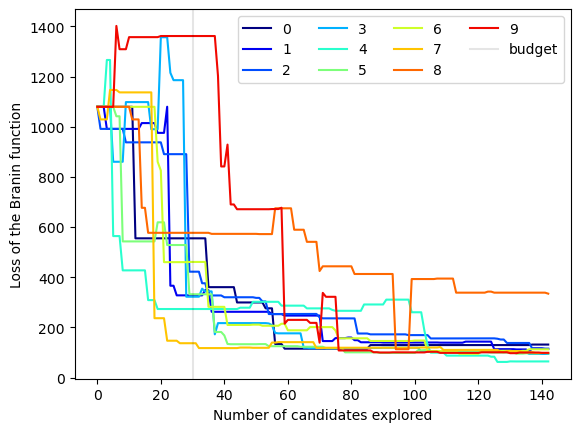

In [39]:
cnt = 0
for l in CL:
    plt.plot(l,label="%i"%cnt,c=mpl.cm.jet(cnt/len(CL)))
    cnt+=1

plt.xlabel('Number of candidates explored')
plt.axvline(B,label='budget',c='k',alpha=0.1)
plt.ylabel('Loss of the Branin function')
plt.legend(loc=0,ncol=4)

In [33]:
cc = []
for c in CL:
    cc.append(c[-1])

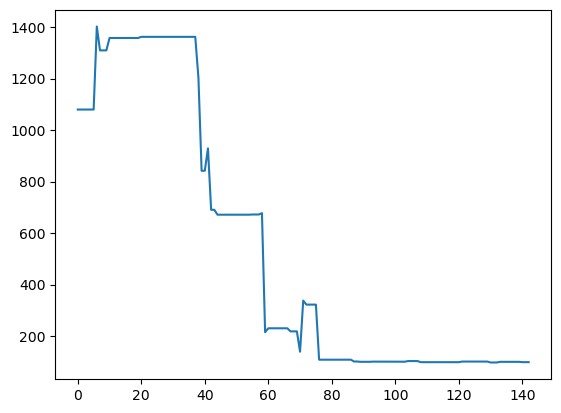

In [34]:
plt.plot(CL[-1])

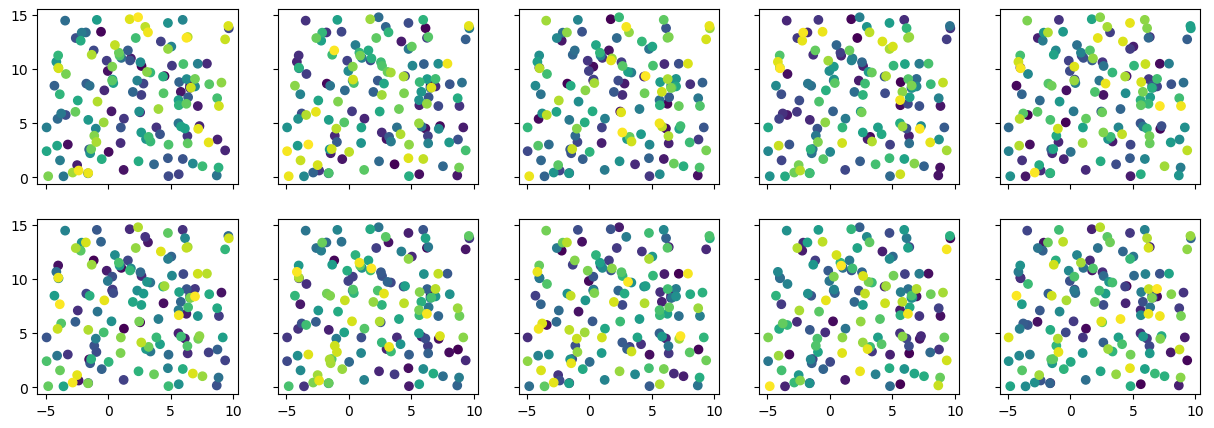

In [35]:
fig, ax = plt.subplots(2,5,figsize=(15,5),sharex=True,sharey=True)
cnt = 0
for i in range(2):
    for j in range(5):
        ll = np.array(Mm[cnt][:-1])
        ax[i,j].scatter(ll[:,0],ll[:,1],c=range(len(ll)))
        cnt+=1

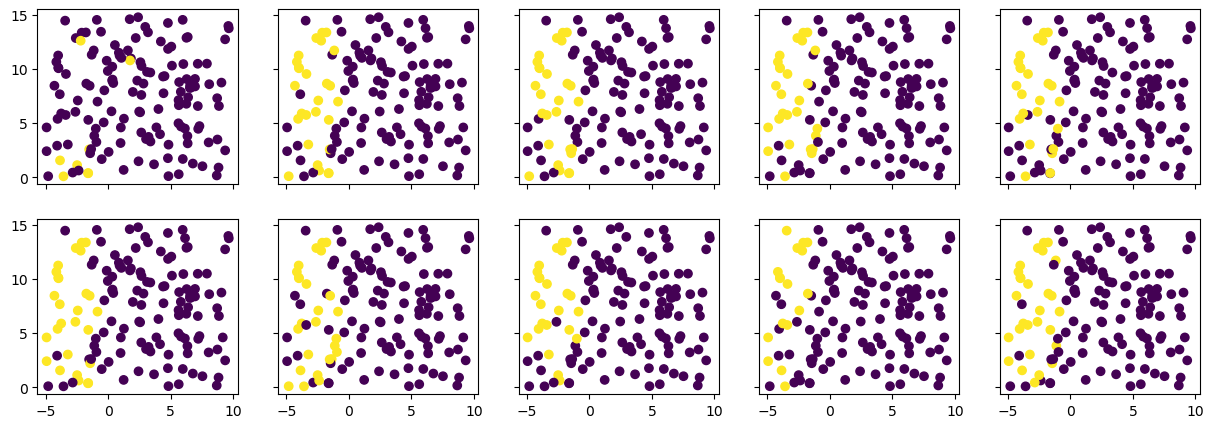

In [36]:
fig, ax = plt.subplots(2,5,figsize=(15,5),sharex=True,sharey=True)
cnt = 0
for i in range(2):
    for j in range(5):
        ll = np.array(Mm[cnt][:-1])
        ax[i,j].scatter(ll[:,0],ll[:,1],c=ll[:,4])
        cnt+=1

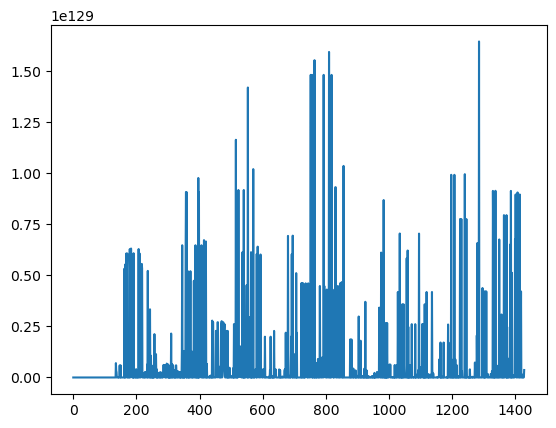

In [37]:
plt.plot(Q_Learner.loss_curve[1:])
plt.xlabel('')